## Notebook exploring the finetuning of XLnet


In [2]:
import os
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import XLNetTokenizer, XLNetForSequenceClassification
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

### Data loading

A custom dataloader has to built, where we will use the existing XLNetTokenizer to encode our input instead of relying on a vocab class


In [3]:
class XLimdbDataset(Dataset):
    def __init__(self,
                 data_dir:str,
                 max_sent_len:int,
                 tokenizer:XLNetTokenizer,
                 is_train:bool=True):
        """
        IMDB Dataset Class
        The dataset will be created by reading all documents inside the file and encoded by XLnet encoder
        
        Args:
            data_dir (str): path to imdb parent folder
            max_sent_len (int): maximum number of words per review
            tokenizer (XLNetTokenizer): XLNet tokenizer
            is_train (bool, optional): is the dataset train? Will take from train folder if True. Defaults to True.
        
        Returns:
            input_ids, attention_mask, labels
        """

        self.tokenizer = tokenizer
        self.max_sent_len = max_sent_len
        self.data_list, self.label_list = self._read_imdb(data_dir, is_train)


    def _read_imdb(self, data_dir, is_train):
        data = []
        labels = []
        data_folder = 'train' if is_train else 'test'
        
        for label, label_folder in enumerate(['neg', 'pos']):
            # Retrieve full path
            full_path = os.path.join(data_dir, data_folder, label_folder)
            for text_file in os.listdir(full_path):
                # Read text
                with open(os.path.join(full_path, text_file), 'r', encoding='utf-8') as f:
                    # Add text and label
                    data.append(f.read())
                    labels.append(label)
        return data, labels
    

    def __len__(self):
        return len(self.data_list)


    def __getitem__(self, idx):
        doc_data = self.data_list[idx]
        # Encode data and add padding automatically
        encoding = self.tokenizer(
            doc_data,
            max_length=self.max_sent_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        # Input_ids, Attention_mask, Label
        return encoding['input_ids'].squeeze(0), encoding['attention_mask'].squeeze(0), torch.tensor(self.label_list[idx], dtype=torch.long)

In [11]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

train_dataset = XLimdbDataset(data_dir="../data/aclImdb",
                            max_sent_len=512,
                            tokenizer=tokenizer)

test_dataset = XLimdbDataset(data_dir="../data/aclImdb",
                            max_sent_len=512,
                            tokenizer=tokenizer,
                            is_train=False)

In [17]:
train_iter = DataLoader(train_dataset,
                        batch_size=64, 
                        shuffle=True,
                        )

test_iter = DataLoader(test_dataset,
                        batch_size=64
                        )

### Model Architecture

We will use a pre-trained XLNetModel from hugging face, but modify the final linear layer and also unfreeze the last layer

In [18]:
class XLNetFineTunedModel(torch.nn.Module):
    def __init__(self,
                 device:str, 
                 num_class:int, 
                 unfreeze_all:bool=False
                 ):
        """
        XLNet model class, loads pretrained xlnet from hugging face
        Option to unfreeze all layers, but if set to false it will only unfreeze the linear layers (classification layers)

        Args:
            device (str): cpu or cuda
            num_class (int): Total number of labels
            unfreeze_all (bool, optional): Unfreeze all layers in XLNet. Defaults to False.
        """
        super().__init__() 
        self.model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=num_class).to(device)

        if not unfreeze_all:
            for name, param in self.model.named_parameters():
                # Retrieve linear classification layers
                if name in ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']:  
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        else:
            # Unfreeze all
            for param in self.model.parameters():
                param.requires_grad = True

    
    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.model(input_ids=input_ids, 
                             attention_mask=attention_mask, 
                             labels=labels)
        return outputs

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlNet_model = XLNetFineTunedModel(device, num_class=2)
print(xlNet_model)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetFineTunedModel(
  (model): XLNetForSequenceClassification(
    (transformer): XLNetModel(
      (word_embedding): Embedding(32000, 768)
      (layer): ModuleList(
        (0-11): 12 x XLNetLayer(
          (rel_attn): XLNetRelativeAttention(
            (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (ff): XLNetFeedForward(
            (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (layer_1): Linear(in_features=768, out_features=3072, bias=True)
            (layer_2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (activation_function): GELUActivation()
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (sequence_summary): SequenceSummary(
      (summary): Linear(in_features=768, out_features=768, b

### Training and evaluation

In [20]:
def eval_model(model:XLNetFineTunedModel,
               test_iter:DataLoader,
               device:str,
               calc_confusion_matrix:bool=False
               ):
    
    """
    Function to evaluate model, returning the Accuracy, Precision, Recall and F1 score

    Args:
        model (XLNetFineTunedModel): Instance of model
        test_iter (DataLoader): test dataloader
        device (str): cpu or cuda
        calc_confusion_matrix (bool, Optional): Boolean if Precision, Recall and F1 score should also be calculated. Defaults to False.
    
    Returns:
        accuracy, recall (None if calc_confusion_matrix == False), precision (None if calc_confusion_matrix == False), f1 (None if calc_confusion_matrix == False)
        
    """
    prediction_list = []
    actual_list = []
    recall, precision, f1 = None, None, None

    # Setup model eval to prevent training
    model.eval()
    for idx, (input_ids, attention_masks, label) in tqdm(enumerate(test_iter), total=len(test_iter)):
        # Append actual scores
        actual_list.append(label.numpy())
        input_ids, attention_masks, label = input_ids.to(device), attention_masks.to(device), label.to(device)
        outputs = model(input_ids, attention_masks, label)
        
        # Append predicted scores
        logits = outputs.logits #Retrieve softmax logits
        predicted = torch.argmax(logits, dim=-1)
        prediction_list.append(predicted.cpu().numpy())

    # Flatten the lists into arrays
    actual_list = np.concatenate(actual_list)
    prediction_list = np.concatenate(prediction_list)

    # Calculate accuracy
    accuracy = accuracy_score(actual_list, prediction_list)

    # Calculate other metrics
    if calc_confusion_matrix:
        recall = recall_score(actual_list, prediction_list)
        precision = precision_score(actual_list, prediction_list)
        f1 = f1_score(actual_list, prediction_list)

    return accuracy, recall, precision, f1

In [21]:
def train_model(model:XLNetFineTunedModel, 
                train_iter:DataLoader, 
                test_iter:DataLoader, 
                num_epochs:int, 
                optimiser, 
                lr_scheduler, 
                device:str,
                show_training_graph:bool,
                best_model_path:str, 
                final_model_path:str):
    
    """
    Function to train and evaluate model
    The model will train on the train_iter, be evaluated on test_iter
    Best model with highest accuracy on test_iter will be saved in best_model_path
    Final model after last epoch will be saved in final_model_path

    Args:
        model (XLNetFineTunedModel): model to be trained
        train_iter (DataLoader): train dataset
        test_iter (DataLoader): test dataset
        num_epochs (int): Number of epochs to train
        optimiser: optimiser
        lr_scheduler: learning rate scheduler, else None
        device (str): cpu or cuda
        show_training_graph (bool): boolean to show the training loss, training acc and test acc graph across epochs
        best_model_path (str): path to best model
        final_model_path (str): path to model aft final epoch training
    """
    train_loss_container = []
    train_acc_container = []
    test_acc_container = []

    best_test_acc = 0

    for epoch in range(num_epochs):
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0

        # Setup training 
        model.train()
        model.to(device)

        for idx, (input_ids, attention_masks, label) in tqdm(enumerate(train_iter), total=len(train_iter)):
            input_ids, attention_masks, label = input_ids.to(device), attention_masks.to(device), label.to(device)

            # Get predictions and loss
            outputs = model(input_ids, attention_masks, label)
            # Loss is automatically calculated with BCE from XLNt
            loss = outputs.loss
            total_train_loss += loss.item()

            # Train
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            if lr_scheduler:
                lr_scheduler.step()

            # Count accuracy
            logits = outputs.logits #Retrieve softmax logits
            predicted = torch.argmax(logits, dim=-1)            
            total_train_correct += (predicted == label).sum().item()
            total_train_samples += label.shape[0]

        # Evaluation for test
        test_acc, _, _, _ = eval_model(model, test_iter, device)

        train_loss_container.append(total_train_loss/len(train_iter)) #total num of batches
        train_acc_container.append(total_train_correct/total_train_samples)
        test_acc_container.append(test_acc)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(model, best_model_path)
            print(f"Best Model Saved at epoch {epoch+1}")

        print(f"Epoch {epoch+1} completed, train_loss: {total_train_loss/len(train_iter)}, train_acc: {total_train_correct/total_train_samples}, test_acc: {test_acc}")

    # Save Final model 
    torch.save(model, final_model_path)

    if show_training_graph:
        # Graph with matplotlib
        # Plot each list
        plt.plot(train_loss_container, label='Train Loss', color='blue')
        plt.plot(train_acc_container, label='Train Acc', color='green')
        plt.plot(test_acc_container, label='Test Acc', color='red')

        # Add labels and legend
        plt.xlabel("Epoch")
        plt.legend()
        plt.show()


100%|██████████| 782/782 [07:39<00:00,  1.70it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.43075520211778334, train_acc: 0.81936, test_acc: 0.88228


100%|██████████| 782/782 [07:38<00:00,  1.70it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.32532962125814174, train_acc: 0.86852, test_acc: 0.89228


100%|██████████| 782/782 [07:38<00:00,  1.70it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.30877110625014587, train_acc: 0.87376, test_acc: 0.896


100%|██████████| 782/782 [07:38<00:00,  1.71it/s]


Best Model Saved at epoch 4
Epoch 4 completed, train_loss: 0.306240277436307, train_acc: 0.87364, test_acc: 0.89712


100%|██████████| 782/782 [07:30<00:00,  1.73it/s]


Best Model Saved at epoch 5
Epoch 5 completed, train_loss: 0.3014941097182386, train_acc: 0.87568, test_acc: 0.90104


100%|██████████| 782/782 [07:31<00:00,  1.73it/s]


Epoch 6 completed, train_loss: 0.30099837985985417, train_acc: 0.87468, test_acc: 0.89956


100%|██████████| 782/782 [07:30<00:00,  1.73it/s]


Epoch 7 completed, train_loss: 0.30119314547771076, train_acc: 0.87464, test_acc: 0.89996


100%|██████████| 782/782 [07:32<00:00,  1.73it/s]


Best Model Saved at epoch 8
Epoch 8 completed, train_loss: 0.3018405164313286, train_acc: 0.87492, test_acc: 0.90156


100%|██████████| 782/782 [07:31<00:00,  1.73it/s]


Epoch 9 completed, train_loss: 0.2973487758365891, train_acc: 0.87504, test_acc: 0.90012


100%|██████████| 782/782 [07:31<00:00,  1.73it/s]


Epoch 10 completed, train_loss: 0.2984601965083567, train_acc: 0.876, test_acc: 0.89844


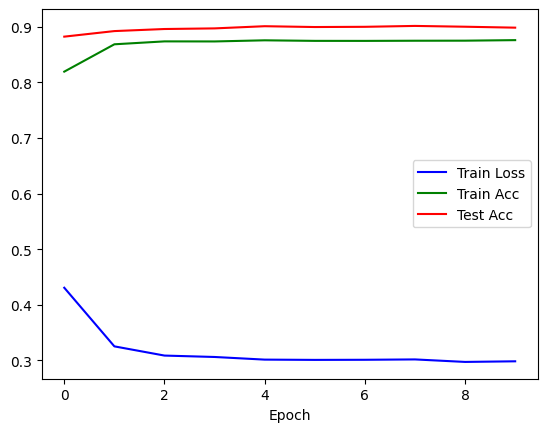

In [16]:
# 512, 32
lr, num_epochs = 2e-5, 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.AdamW(xlNet_model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=10)

train_model(xlNet_model, train_iter, test_iter, num_epochs, optimizer, None, device, True, '../models/best_XLNET_2.pt', '../models/final_XLNET_2.pt')

100%|██████████| 391/391 [09:50<00:00,  1.51s/it]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.5045437796798813, train_acc: 0.78544, test_acc: 0.86676


100%|██████████| 391/391 [09:50<00:00,  1.51s/it]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.37543179258666076, train_acc: 0.85088, test_acc: 0.88124


100%|██████████| 391/391 [09:51<00:00,  1.51s/it]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.3443857202749423, train_acc: 0.85992, test_acc: 0.88616


100%|██████████| 391/391 [09:51<00:00,  1.51s/it]


Best Model Saved at epoch 4
Epoch 4 completed, train_loss: 0.3250163015349747, train_acc: 0.8676, test_acc: 0.88948


100%|██████████| 391/391 [09:51<00:00,  1.51s/it]


Best Model Saved at epoch 5
Epoch 5 completed, train_loss: 0.31601066849268306, train_acc: 0.87256, test_acc: 0.89324


100%|██████████| 391/391 [09:51<00:00,  1.51s/it]


Best Model Saved at epoch 6
Epoch 6 completed, train_loss: 0.31287727815568295, train_acc: 0.87224, test_acc: 0.8946


100%|██████████| 391/391 [09:51<00:00,  1.51s/it]


Best Model Saved at epoch 7
Epoch 7 completed, train_loss: 0.30683751457639974, train_acc: 0.87376, test_acc: 0.89672


100%|██████████| 391/391 [09:51<00:00,  1.51s/it]


Best Model Saved at epoch 8
Epoch 8 completed, train_loss: 0.30328448638891625, train_acc: 0.87724, test_acc: 0.89732


100%|██████████| 391/391 [09:51<00:00,  1.51s/it]


Best Model Saved at epoch 9
Epoch 9 completed, train_loss: 0.29904212735955366, train_acc: 0.8772, test_acc: 0.89864


100%|██████████| 391/391 [09:50<00:00,  1.51s/it]


Best Model Saved at epoch 10
Epoch 10 completed, train_loss: 0.3007134422469322, train_acc: 0.8762, test_acc: 0.89988


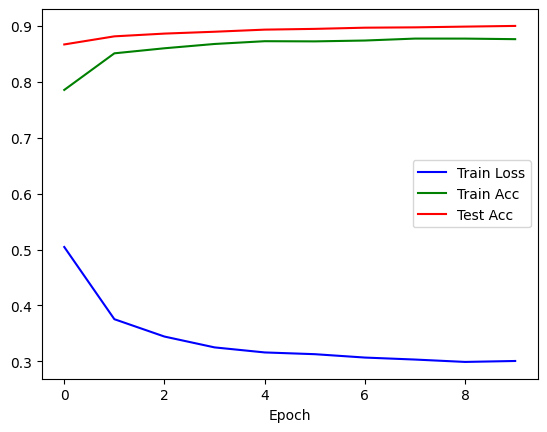

In [22]:
# 512, 64
lr, num_epochs = 5e-5, 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.AdamW(xlNet_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.25, total_iters=10)

train_model(xlNet_model, train_iter, test_iter, num_epochs, optimizer, scheduler, device, True, '../models/best_XLNET.pt', '../models/final_XLNET.pt')

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.40274247569043925, train_acc: 0.82312, test_acc: 0.8678


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.3631646537872227, train_acc: 0.84244, test_acc: 0.87348


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.3560328111624169, train_acc: 0.84668, test_acc: 0.87404


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Best Model Saved at epoch 4
Epoch 4 completed, train_loss: 0.3538662694451754, train_acc: 0.8472, test_acc: 0.875


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Best Model Saved at epoch 5
Epoch 5 completed, train_loss: 0.34718260081375346, train_acc: 0.85112, test_acc: 0.87676


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Best Model Saved at epoch 6
Epoch 6 completed, train_loss: 0.3466680819344947, train_acc: 0.85188, test_acc: 0.878


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Epoch 7 completed, train_loss: 0.3446452740741813, train_acc: 0.85188, test_acc: 0.87796


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Best Model Saved at epoch 8
Epoch 8 completed, train_loss: 0.3458651092732349, train_acc: 0.85396, test_acc: 0.87936


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Epoch 9 completed, train_loss: 0.3430505638842083, train_acc: 0.85084, test_acc: 0.87664


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Epoch 10 completed, train_loss: 0.3459961098020949, train_acc: 0.85108, test_acc: 0.8792


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Epoch 11 completed, train_loss: 0.3458052263464159, train_acc: 0.85232, test_acc: 0.8748


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Epoch 12 completed, train_loss: 0.34337434069732264, train_acc: 0.85204, test_acc: 0.87612


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Epoch 13 completed, train_loss: 0.3384465157147259, train_acc: 0.8558, test_acc: 0.87312


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Best Model Saved at epoch 14
Epoch 14 completed, train_loss: 0.34177116272242175, train_acc: 0.8544, test_acc: 0.87988


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Epoch 15 completed, train_loss: 0.34203162392996767, train_acc: 0.8528, test_acc: 0.87932


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Best Model Saved at epoch 16
Epoch 16 completed, train_loss: 0.33681703513235695, train_acc: 0.85564, test_acc: 0.88064


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Epoch 17 completed, train_loss: 0.3376228979329014, train_acc: 0.85464, test_acc: 0.87872


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Epoch 18 completed, train_loss: 0.3394423529238957, train_acc: 0.85504, test_acc: 0.88052


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Epoch 19 completed, train_loss: 0.33551625255733497, train_acc: 0.85576, test_acc: 0.8804


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Best Model Saved at epoch 20
Epoch 20 completed, train_loss: 0.33854747466419055, train_acc: 0.85368, test_acc: 0.88088


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Epoch 21 completed, train_loss: 0.3365311954561097, train_acc: 0.855, test_acc: 0.87996


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Epoch 22 completed, train_loss: 0.33408832954018924, train_acc: 0.85588, test_acc: 0.87848


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Epoch 23 completed, train_loss: 0.3320671462875498, train_acc: 0.8582, test_acc: 0.87772


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Epoch 24 completed, train_loss: 0.3291775907778069, train_acc: 0.85812, test_acc: 0.88008


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Epoch 25 completed, train_loss: 0.3348424223149219, train_acc: 0.85708, test_acc: 0.87864


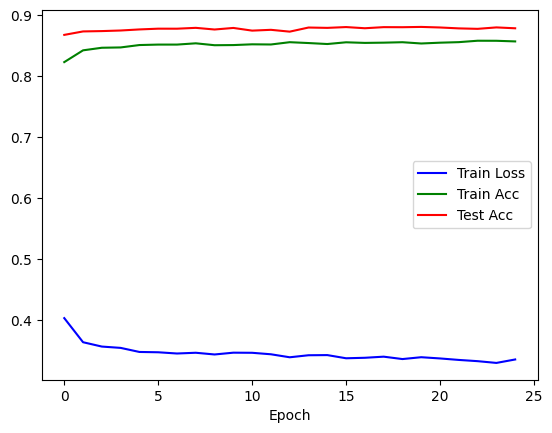

In [ ]:
# 256, 64
lr, num_epochs = 5e-4, 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.AdamW(xlNet_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=25)

train_model(xlNet_model, train_iter, test_iter, num_epochs, optimizer, scheduler, device, True, '../models/best_XLNET_25_256.pt', '../models/final_XLNET_25_256.pt')

### Evaluation

In [23]:
model = torch.load('../models/best_XLNET_2.pt')

In [24]:
eval_model(model, test_iter, device, True)

100%|██████████| 391/391 [09:40<00:00,  1.48s/it]


(0.90156, 0.90952, 0.8952673438853453, 0.9023373943410453)

In [25]:
model = torch.load('../models/best_XLNET.pt')
eval_model(model, test_iter, device, True)

100%|██████████| 391/391 [09:46<00:00,  1.50s/it]


(0.89988, 0.91424, 0.8887160743448168, 0.9012973697701013)